In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pickle
from torch.utils.data import Dataset

In [18]:
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, return_logits=False):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(self.relu(self.fc1(x)))
        logits = self.fc2(x)
        probabilities = torch.sigmoid(logits)  # Apply sigmoid for probabilities

        if return_logits:
            return logits  # Return raw logits
        return probabilities  # Return probabilities by default



In [2]:
import os
import shutil

def consolidate_images(image_dir_base, target_dir):

    for sub_dir in os.listdir(image_dir_base):
        sub_dir_path = os.path.join(image_dir_base, sub_dir)

        if not os.path.isdir(sub_dir_path):
            continue

        for file_name in os.listdir(sub_dir_path):
            src_path = os.path.join(sub_dir_path, file_name)
            dst_path = os.path.join(target_dir, file_name)

            if os.path.exists(dst_path):
                print(f"File already exists: {dst_path}. Skipping...")
                continue

            shutil.copy(src_path, dst_path)
            print(f"Copied: {src_path} -> {dst_path}")

image_dir_base = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/data'
target_dir = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images'

consolidate_images(image_dir_base, target_dir)


Copied: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/data/jalebi/jalebi_197.jpg -> /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images/jalebi_197.jpg
Copied: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/data/jalebi/jalebi_183.jpg -> /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images/jalebi_183.jpg
Copied: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/data/jalebi/jalebi_154.jpg -> /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images/jalebi_154.jpg
Copied: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/data/jalebi/jalebi_140.jpg -> /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images/jal

In [14]:
class BinaryLabelDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        with open(annotation_file, "r") as f:
            lines = f.readlines()

        for line in lines[1:]:  # Skip the header row
            parts = line.strip().split(",")
            img_file, label = parts[0], int(parts[1])
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(self.image_dir, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError):
            print(f"Skipping invalid or missing image file: {img_path}")
            return self[idx + 1 if idx + 1 < len(self) else 0]  # Skip to next valid image
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)



def train_all_classes(image_dir_base, annotation_dir, output_dir, epochs=10, batch_size=32, learning_rate=0.001):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    food_names = ['jalebi', 'samosa', 'pakode', 'chapati', 'chai', 'dal_makhani', 'kulfi', 'paani_puri', 'momos', 'kadai_paneer', 'dhokla', 'idli', 'chole_bhature', 'pav_bhaji', 'burger', 'kaathi_rolls', 'masala_dosa', 'butter_naan', 'pizza', 'fried_rice']

    print(food_names)

    for food_name in food_names:
        print(f"Training for class: {food_name}...")

        image_dir = image_dir_base
        annotation_file = os.path.join(annotation_dir, f"annotation_{food_name}.csv")
        save_path = os.path.join(output_dir, f"model_{food_name}.pth")

        if not os.path.exists(annotation_file):
            print(f"Annotation file for {food_name} not found, skipping...")
            continue

        train_binary_classifier(
            food_name,
            image_dir,
            annotation_file,
            save_path,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate
        )
        print(food_names)
        print(f"Model for {food_name} saved at {save_path}.")

image_dir_base = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images'
annotation_dir = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/final_annotation_balanced'
output_dir = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models'


def train_binary_classifier(class_name, image_dir, annotation_file, save_path, epochs=10, batch_size=32, learning_rate=0.001):
    """
    Trains a binary classifier for a specific food class.
    Args:
        class_name (str): Food class name.
        image_dir (str): Path to the consolidated image directory.
        annotation_file (str): Path to the annotation file for this class.
        save_path (str): Path to save the trained model.
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
    """
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  
        transforms.ToTensor(),
    ])

    dataset = BinaryLabelDataset(image_dir, annotation_file, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = CustomCNN()
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images, labels.unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Class {class_name} Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

    torch.save(model.state_dict(), save_path)

train_all_classes(image_dir_base, annotation_dir, output_dir, epochs=25, batch_size=32, learning_rate=0.001)



['jalebi', 'samosa', 'pakode', 'chapati', 'chai', 'dal_makhani', 'kulfi', 'paani_puri', 'momos', 'kadai_paneer', 'dhokla', 'idli', 'chole_bhature', 'pav_bhaji', 'burger', 'kaathi_rolls', 'masala_dosa', 'butter_naan', 'pizza', 'fried_rice']
Training for class: jalebi...
Class jalebi Epoch [1/25], Loss: 0.5941
Class jalebi Epoch [2/25], Loss: 0.4364
Class jalebi Epoch [3/25], Loss: 0.4150
Class jalebi Epoch [4/25], Loss: 0.3915
Class jalebi Epoch [5/25], Loss: 0.4019
Class jalebi Epoch [6/25], Loss: 0.3831
Class jalebi Epoch [7/25], Loss: 0.3542
Class jalebi Epoch [8/25], Loss: 0.3150
Class jalebi Epoch [9/25], Loss: 0.2990
Class jalebi Epoch [10/25], Loss: 0.2974
Class jalebi Epoch [11/25], Loss: 0.2943
Class jalebi Epoch [12/25], Loss: 0.2375
Class jalebi Epoch [13/25], Loss: 0.2507
Class jalebi Epoch [14/25], Loss: 0.2274
Class jalebi Epoch [15/25], Loss: 0.1812
Class jalebi Epoch [16/25], Loss: 0.1406
Class jalebi Epoch [17/25], Loss: 0.1418
Class jalebi Epoch [18/25], Loss: 0.1402
C

In [36]:
import torch
from torchvision import transforms
from PIL import Image

def run_inference_individual(image_path, model_path, threshold=0.5):
    model = CustomCNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  

    with torch.no_grad():
        output = model(image)  
        prediction = output.item()

    return prediction

image_path = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images/chapati100.jpg'
model_path = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_chapati.pth'
result = run_inference_individual(image_path, model_path)
print(f"Class detected: {result}")


Class detected: 0.9979311227798462


In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from torch import nn

def get_confidence_scores(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0) 

    model.eval()

    with torch.no_grad():
        logits = model(image) 
        probabilities = torch.sigmoid(logits) 
        confidence = probabilities.item()

    return confidence

def run_inference_ensemble(image_path, model_paths):
    confidence_scores = {}
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    for class_name, model_path in model_paths.items():
        model = CustomCNN()
        model.load_state_dict(torch.load(model_path))
        model.eval()

        confidence = get_confidence_scores(image_path, model, transform)
        confidence_scores[class_name] = confidence

    max_class = max(confidence_scores, key=confidence_scores.get)
    max_confidence = confidence_scores[max_class]

    print(f"The class with the maximum confidence is '{max_class}' with a confidence of {max_confidence:.4f}")

    return confidence_scores



image_path = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images/pakode_103.jpg'
model_paths = {
 'jalebi': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_jalebi.pth',
 'samosa': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_samosa.pth',
 'pakode': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_pakode.pth',
 'chapati': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_chapati.pth',
 'chai': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_chai.pth',
 'dal_makhani': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_dal_makhani.pth',
 'kulfi': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_kulfi.pth',
 'paani_puri': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_paani_puri.pth',
 'momos': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_momos.pth',
 'kadai_paneer': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_kadai_paneer.pth',
 'dhokla': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_dhokla.pth',
 'idli': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_idli.pth',
 'chole_bhature': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_chole_bhature.pth',
 'pav_bhaji': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_pav_bhaji.pth',
 'burger': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_burger.pth',
 'kaathi_rolls': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_kaathi_rolls.pth',
 'masala_dosa': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_masala_dosa.pth',
 'butter_naan': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_butter_naan.pth',
 'pizza': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_pizza.pth',
 'fried_rice': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_fried_rice.pth'
}


ensemble_result = run_inference_ensemble(image_path, model_paths)
print(f"Ensemble Predictions: {ensemble_result}")


The class with the maximum confidence is 'pakode' with a confidence of 0.7310
Ensemble Predictions: {'jalebi': 0.5025994181632996, 'samosa': 0.5057632923126221, 'pakode': 0.731044590473175, 'chapati': 0.5049248337745667, 'chai': 0.5, 'dal_makhani': 0.5016757845878601, 'kulfi': 0.5, 'paani_puri': 0.5112915635108948, 'momos': 0.5005119442939758, 'kadai_paneer': 0.6164517402648926, 'dhokla': 0.5203144550323486, 'idli': 0.5000267028808594, 'chole_bhature': 0.5004090666770935, 'pav_bhaji': 0.5152749419212341, 'burger': 0.5642133951187134, 'kaathi_rolls': 0.5000000596046448, 'masala_dosa': 0.5000027418136597, 'butter_naan': 0.5, 'pizza': 0.5000001788139343, 'fried_rice': 0.7198454141616821}


In [51]:
from torchsummary import summary

model_paths = {
 'jalebi': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_jalebi.pth',
 'samosa': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_samosa.pth',
 'pakode': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_pakode.pth',
 'chapati': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_chapati.pth',
 'chai': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_chai.pth',
 'dal_makhani': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_dal_makhani.pth',
 'kulfi': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_kulfi.pth',
 'paani_puri': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_paani_puri.pth',
 'momos': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_momos.pth',
 'kadai_paneer': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_kadai_paneer.pth',
 'dhokla': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_dhokla.pth',
 'idli': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_idli.pth',
 'chole_bhature': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_chole_bhature.pth',
 'pav_bhaji': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_pav_bhaji.pth',
 'burger': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_burger.pth',
 'kaathi_rolls': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_kaathi_rolls.pth',
 'masala_dosa': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_masala_dosa.pth',
 'butter_naan': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_butter_naan.pth',
 'pizza': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_pizza.pth',
 'fried_rice': '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_fried_rice.pth'
}

for class_name, model_path in model_paths.items():

        model = CustomCNN()
        print(summary(model, input_size=(3, 64, 64)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Linear-10                  [-1, 256]       2,097,408
             ReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 1]             257
Total params: 2,190,913
Trainable param

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import cv2
from tensorflow.keras import layers,models


In [ ]:
modelpath="/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/model/epoch_100_cnn_indian_food.h5"
loaded_model = tf.keras.models.load_model(modelpath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

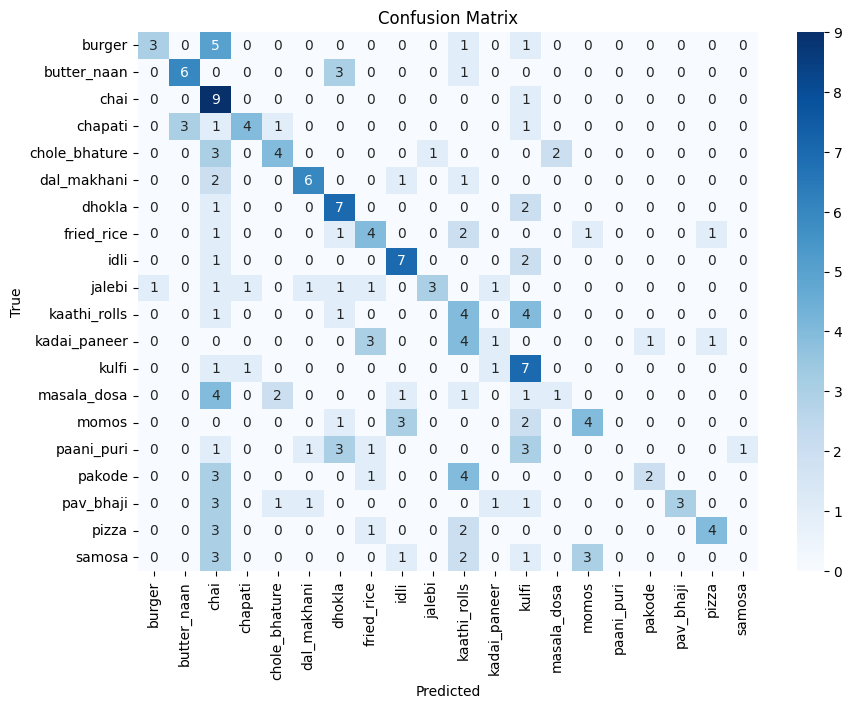

Accuracy: 39.50%


In [ ]:

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def predict_image(image, model):
    test_img = cv2.imread(image)
    
    test_img = cv2.resize(test_img, (224, 224))
    test_img = np.expand_dims(test_img, axis=0)
    
    result = model.predict(test_img)
    
    class_names = {
        0: 'burger', 1: 'butter_naan', 2: 'chai', 3: 'chapati', 4: 'chole_bhature', 5: 'dal_makhani',
        6: 'dhokla', 7: 'fried_rice', 8: 'idli', 9: 'jalebi', 10: 'kaathi_rolls', 11: 'kadai_paneer',
        12: 'kulfi', 13: 'masala_dosa', 14: 'momos', 15: 'paani_puri', 16: 'pakode', 17: 'pav_bhaji',
        18: 'pizza', 19: 'samosa'
    }
    
    r = np.argmax(result)
    return r, class_names[r] 

def evaluate_and_plot_confusion_matrix(image_dir, model):
    all_predictions = []
    all_true_labels = []
    
    class_names = {
        0: 'burger', 1: 'butter_naan', 2: 'chai', 3: 'chapati', 4: 'chole_bhature', 5: 'dal_makhani',
        6: 'dhokla', 7: 'fried_rice', 8: 'idli', 9: 'jalebi', 10: 'kaathi_rolls', 11: 'kadai_paneer',
        12: 'kulfi', 13: 'masala_dosa', 14: 'momos', 15: 'paani_puri', 16: 'pakode', 17: 'pav_bhaji',
        18: 'pizza', 19: 'samosa'
    }
    class_index_map = {v: k for k, v in class_names.items()} 
    
    for class_name in os.listdir(image_dir):
        class_folder = os.path.join(image_dir, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                if image_name.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
                    true_label = class_index_map[class_name]  # Convert true class name to index
                    predicted_index, _ = predict_image(image_path, model)  # Predict using the model
                    
                    all_true_labels.append(true_label)
                    all_predictions.append(predicted_index)
    
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    correct_predictions = cm.diagonal().sum()
    total_predictions = cm.sum() 
    accuracy = correct_predictions / total_predictions * 100
    print(f'Accuracy: {accuracy:.2f}%')

image_dir = "/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples"  # Path to the directory containing class folder
evaluate_and_plot_confusion_matrix(image_dir, loaded_model)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import cv2
from tensorflow.keras import layers,models

def predict_image(image, model):

    test_img=cv2.imread(image)
    plt.imshow(test_img)
    
    test_img=cv2.resize(test_img, (224,224))
    test_img=np.expand_dims(test_img, axis=0)
    
    result=model.predict(test_img)

    class_names={
    0:'burger' ,1:'butter_naan' ,2:'chai' ,3:'chapati' ,4:'chole_bhature' ,5:'dal_makhani' ,
    6:'dhokla' ,7:'fried_rice' ,8:'idli' ,9:'jalebi' ,10:'kaathi_rolls' ,
    11:'kadai_paneer' ,12:'kulfi' ,13:'masala_dosa' ,14:'momos' ,15:'paani_puri' ,
    16:'pakode' ,17:'pav_bhaji' ,18:'pizza' ,19:'samosa'}
    
    r=np.argmax(result)
    print(class_names[r])

image_dir = "/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples"  # Path to the directory containing class folders
model_path = "/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples"  # Path to the directory containing class folders
loaded_model = tf.keras.models.load_model(model_path)
predict_image(imagepath, loaded_model)

NameError: name 'cm' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


def evaluate_classifier_with_metrics(model_path, test_dataset, threshold=0.5):
    model = CustomCNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    y_true = []
    y_pred = []

    for image, label in test_dataset:
        image = image.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            output = model(image)  # Get sigmoid probability
            prediction = 1 if output.item() >= threshold else 0

        y_true.append(label.item())
        y_pred.append(prediction)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    accuracy = accuracy_score(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Present", "Present"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_path.split('/')[-1].replace('model_', '').replace('.pth', '')}")
    plt.show()

    print(f"Accuracy: {accuracy:.2f}")
    return cm, accuracy

from torch.utils.data import DataLoader

test_dataset = BinaryLabelDataset(
    image_dir="/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/all_images",
    annotation_file="/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/annotation/annotations_masala_dosa.csv",
    transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
)

cm_burger = evaluate_classifier_with_metrics(
    model_path="/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_naan.pth",
    test_dataset=test_dataset
)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/annotation/annotations_naan.csv'

Evaluating jalebi classifier...


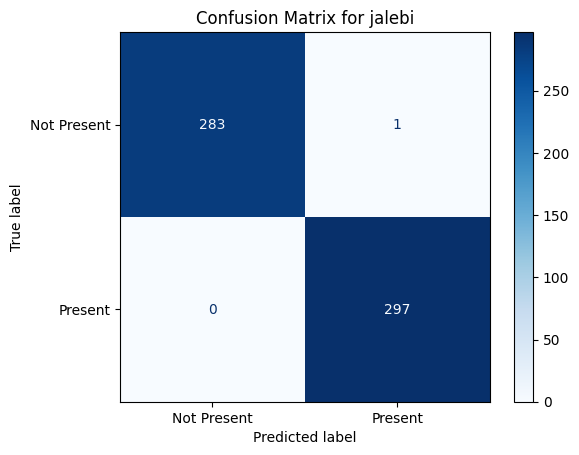

Accuracy: 1.00
Evaluating samosa classifier...


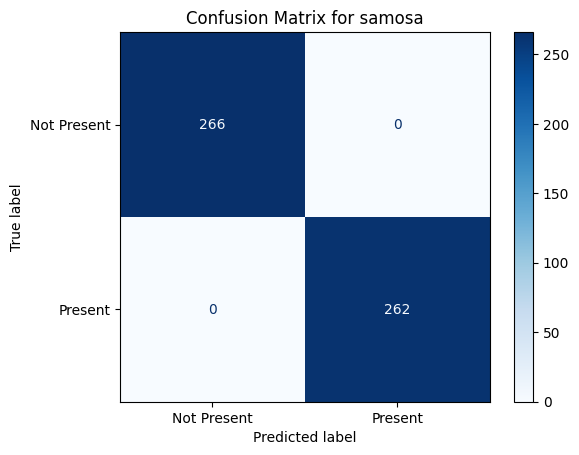

Accuracy: 1.00
Evaluating pakode classifier...


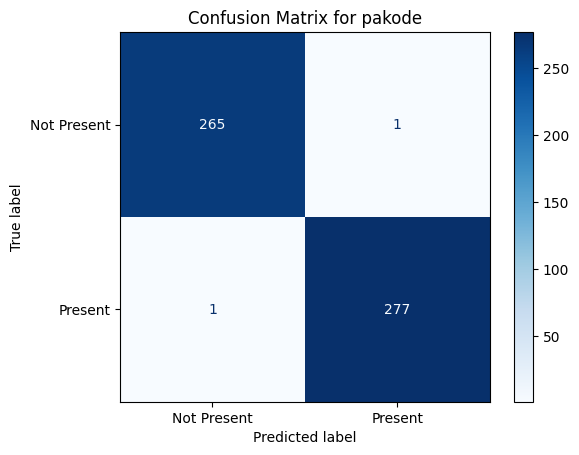

Accuracy: 1.00
Evaluating chapati classifier...


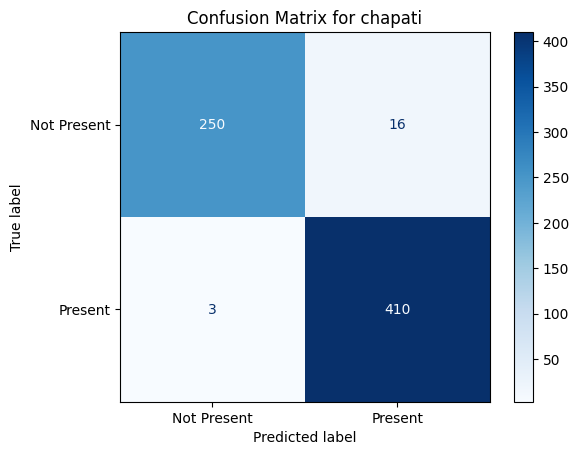

Accuracy: 0.97
Evaluating chai classifier...


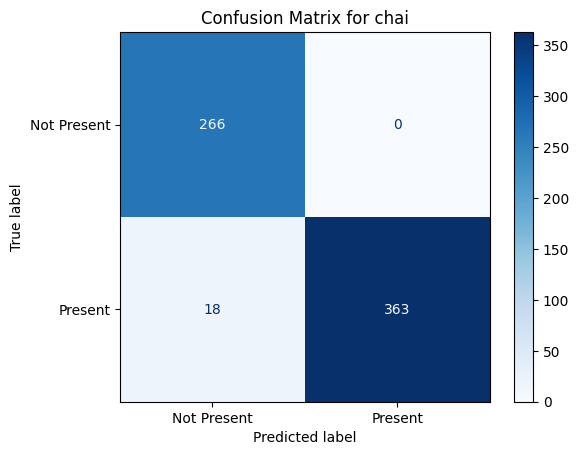

Accuracy: 0.97
Evaluating dal_makhani classifier...


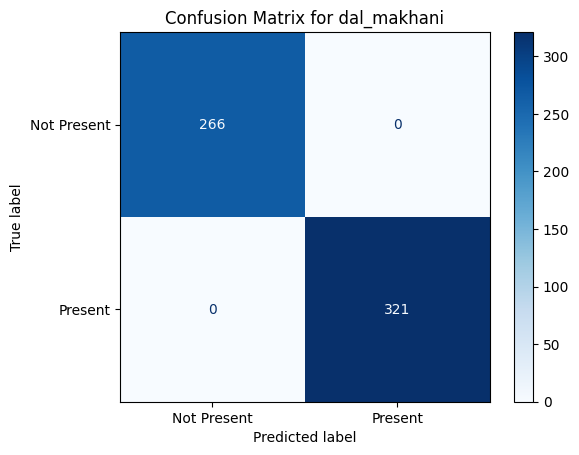

Accuracy: 1.00
Evaluating kulfi classifier...


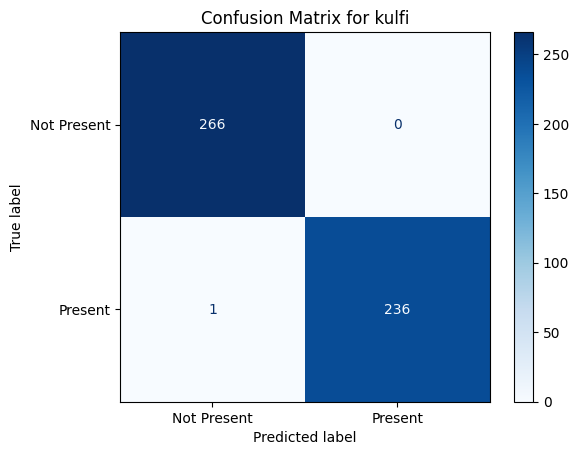

Accuracy: 1.00
Evaluating paani_puri classifier...


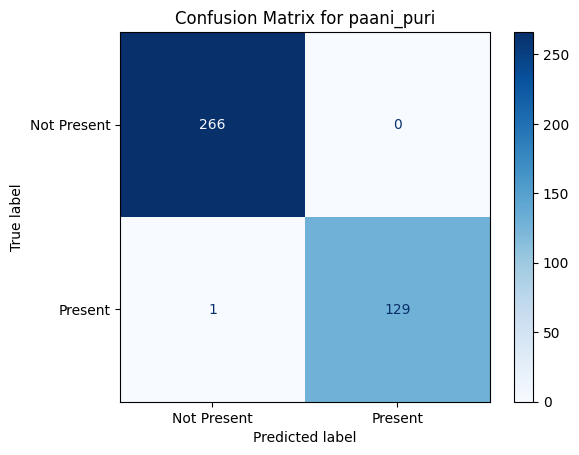

Accuracy: 1.00
Evaluating momos classifier...


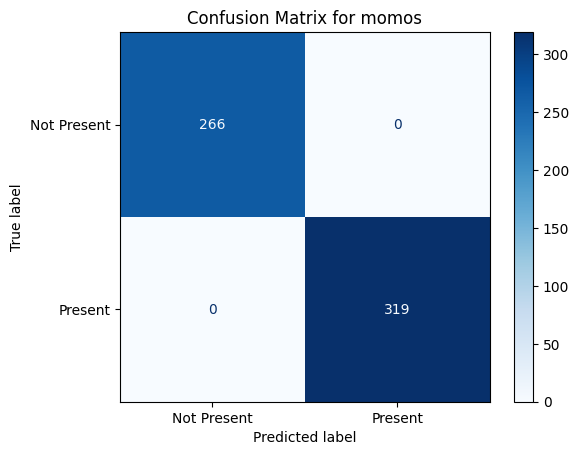

Accuracy: 1.00
Evaluating kadai_paneer classifier...


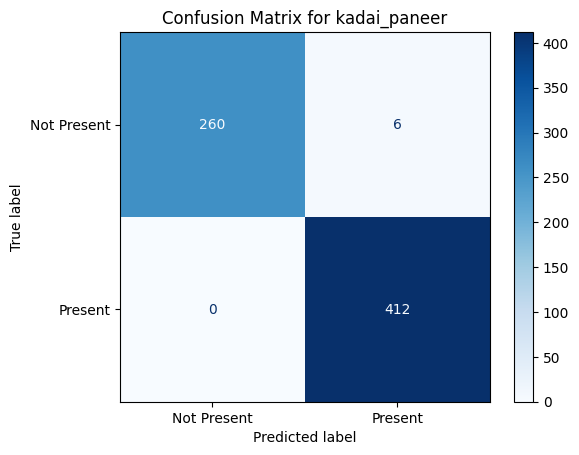

Accuracy: 0.99
Evaluating dhokla classifier...


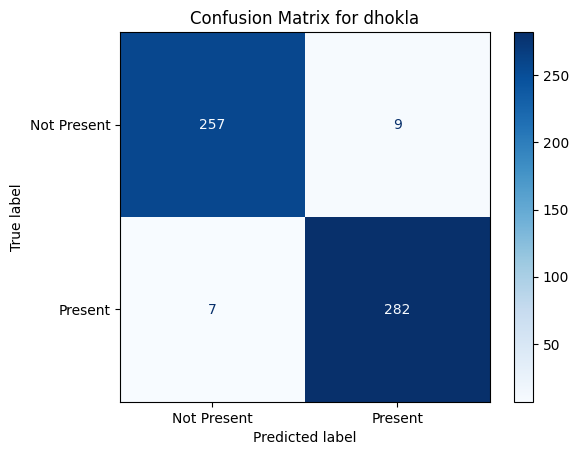

Accuracy: 0.97
Evaluating idli classifier...


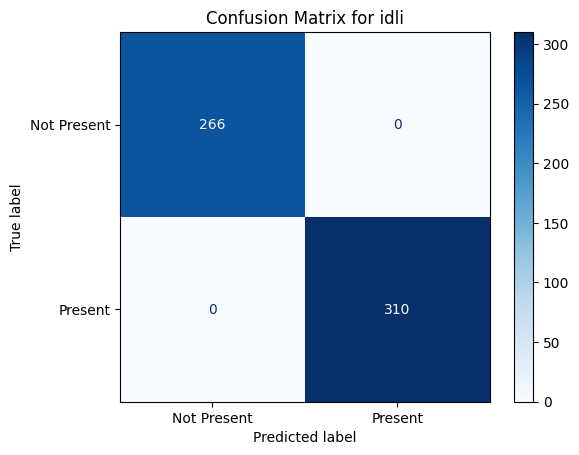

Accuracy: 1.00
Evaluating chole_bhature classifier...


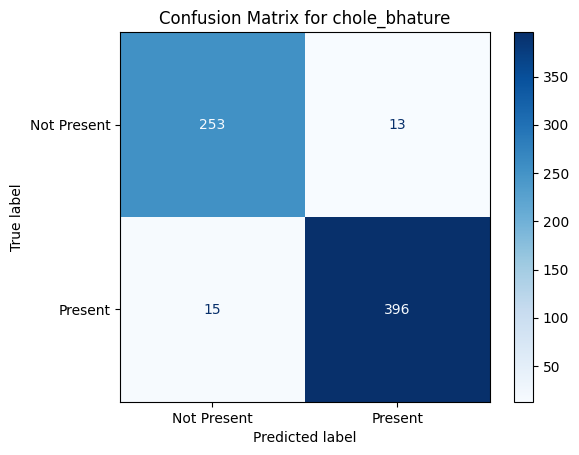

Accuracy: 0.96
Evaluating pav_bhaji classifier...


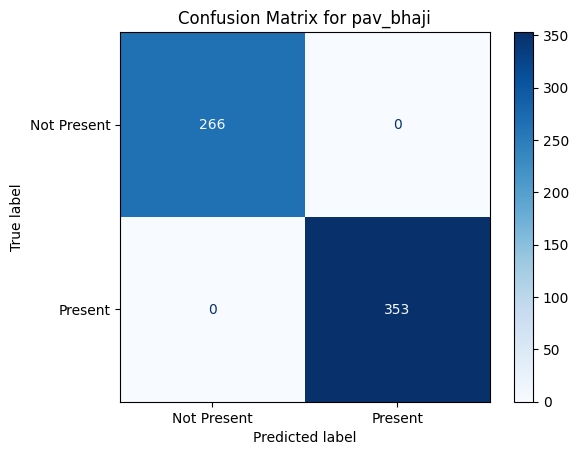

Accuracy: 1.00
Evaluating burger classifier...


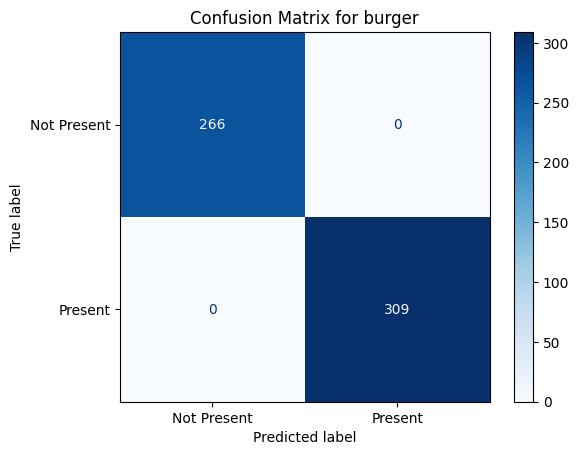

Accuracy: 1.00
Evaluating kaathi_rolls classifier...


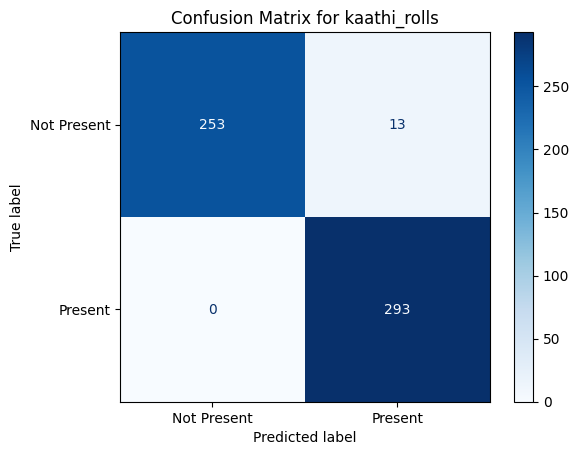

Accuracy: 0.98
Evaluating masala_dosa classifier...


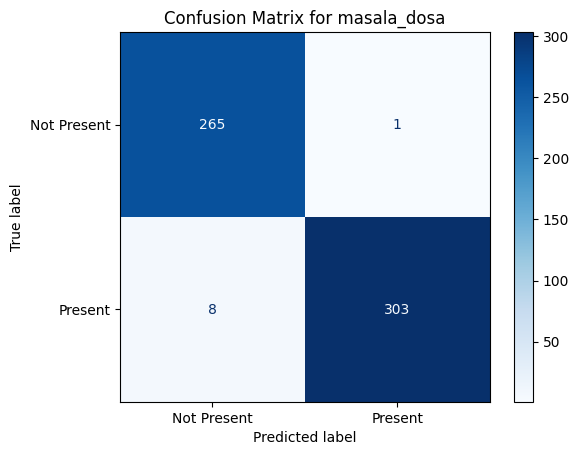

Accuracy: 0.98
Evaluating butter_naan classifier...


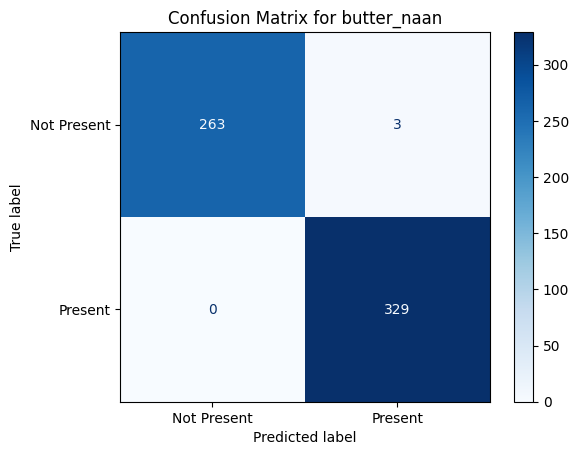

Accuracy: 0.99
Evaluating pizza classifier...


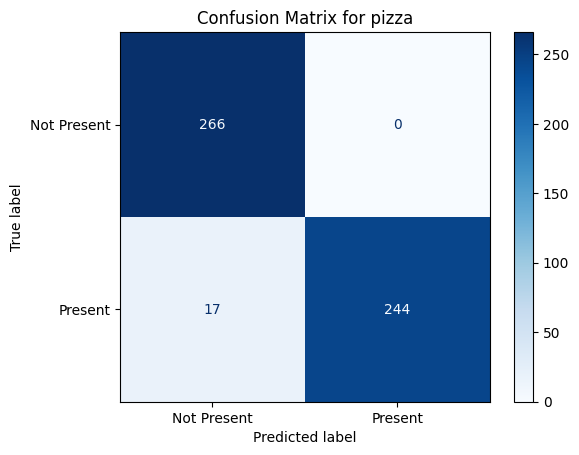

Accuracy: 0.97
Evaluating fried_rice classifier...
File not found: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/all_images/fried_rice010.jpeg. Skipping...
File not found: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/all_images/fried_rice024.jpeg. Skipping...


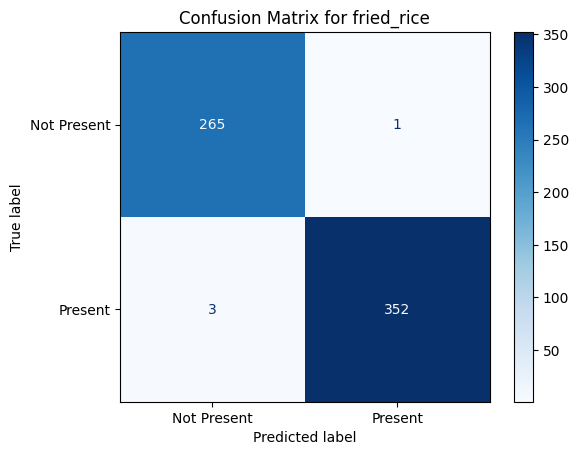

Accuracy: 0.99
Classifier Accuracies:
jalebi: 1.00
samosa: 1.00
pakode: 1.00
chapati: 0.97
chai: 0.97
dal_makhani: 1.00
kulfi: 1.00
paani_puri: 1.00
momos: 1.00
kadai_paneer: 0.99
dhokla: 0.97
idli: 1.00
chole_bhature: 0.96
pav_bhaji: 1.00
burger: 1.00
kaathi_rolls: 0.98
masala_dosa: 0.98
butter_naan: 0.99
pizza: 0.97
fried_rice: 0.99


In [ ]:
def evaluate_all_classifiers_with_metrics(model_paths, annotation_dir, image_dir):
    accuracies = {}

    for class_name, model_path in model_paths.items():
        print(f"Evaluating {class_name} classifier...")
        
        test_dataset = BinaryLabelDataset(
            image_dir=image_dir,
            annotation_file=f"{annotation_dir}/annotation_{class_name}.csv",
            transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
        )

        cm, accuracy = evaluate_classifier_with_metrics(model_path, test_dataset)
        accuracies[class_name] = accuracy

    return accuracies

all_accuracies = evaluate_all_classifiers_with_metrics(model_paths, annotation_dir, image_dir_base)

print("Classifier Accuracies:")
for class_name, accuracy in all_accuracies.items():
    print(f"{class_name}: {accuracy:.2f}")
    



In [31]:
def evaluate_all_classifiers_with_metrics(model_paths, annotation_dir, image_dir):
    accuracies = {}

    for class_name, model_path in model_paths.items():
        print(f"Evaluating {class_name} classifier...")
        
        test_dataset = BinaryLabelDataset(
            image_dir=image_dir,
            annotation_file=f"{annotation_dir}/annotation_{class_name}.csv",
            transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
        )

        cm, accuracy = evaluate_classifier_with_metrics(model_path, test_dataset)
        accuracies[class_name] = accuracy

    return accuracies

all_accuracies = evaluate_all_classifiers_with_metrics(model_paths, annotation_dir, image_dir_base)

print("Classifier Accuracies:")
for class_name, accuracy in all_accuracies.items():
    print(f"{class_name}: {accuracy:.2f}")
    



Evaluating jalebi classifier...


NameError: name 'evaluate_classifier_with_metrics' is not defined

In [54]:
import os
import shutil
import random

def create_balanced_datasets(data_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    for class_name in classes:
        print(f"Creating dataset for class: {class_name}")

        class_dir = os.path.join(output_dir, f"dataset_{class_name}")
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        class_full_dir = os.path.join(data_dir, class_name)
        all_files = [f for f in os.listdir(class_full_dir) if os.path.isfile(os.path.join(class_full_dir, f))]

        random_files = random.sample(all_files, 10)

        for file in random_files:
            src = os.path.join(class_full_dir, file)
            dst = os.path.join(class_dir, file)
            shutil.copy(src, dst)

        print(f"Dataset for class '{class_name}' created at {class_dir}")

data_dir = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/data'  # Directory with full data per class
output_dir = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples'  # Directory to save the resulting datasets

create_balanced_datasets(data_dir, output_dir)


Creating dataset for class: jalebi
Dataset for class 'jalebi' created at /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples/dataset_jalebi
Creating dataset for class: samosa
Dataset for class 'samosa' created at /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples/dataset_samosa
Creating dataset for class: pakode
Dataset for class 'pakode' created at /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples/dataset_pakode
Creating dataset for class: chapati
Dataset for class 'chapati' created at /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples/dataset_chapati
Creating dataset for class: chai
Dataset for class 'chai' created at /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/random_samples/dataset_chai
Creating dataset for cl

In [39]:
import os
import csv

def generate_annotation_files(output_dir):
    datasets = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]

    for dataset in datasets:
        food = dataset.replace("dataset_", "")
        dataset_path = os.path.join(output_dir, dataset)

        annotation_file = os.path.join(output_dir, f"annotation_{food}.csv")

        with open(annotation_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["filename", "label"])

            for image_file in os.listdir(dataset_path):
                if image_file.startswith(food):
                    label = 1
                else:
                    label = 0
                writer.writerow([image_file, label])

        print(f"Annotation file for '{food}' created at: {annotation_file}")

output_dir = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/blast'
generate_annotation_files(output_dir)


Annotation file for 'fried_rice' created at: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/blast/annotation_fried_rice.csv
Annotation file for 'chai' created at: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/blast/annotation_chai.csv
Annotation file for 'kadai_paneer' created at: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/blast/annotation_kadai_paneer.csv
Annotation file for 'pizza' created at: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/blast/annotation_pizza.csv
Annotation file for 'pakode' created at: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/blast/annotation_pakode.csv
Annotation file for 'samosa' created at: /Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/blast/annotation_samosa.csv
Annotation fil

In [ ]:
def get_confidence_scores(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)

    model.eval()

    with torch.no_grad():
        logits = model(image, return_logits=True) 
        probabilities = torch.sigmoid(logits) 
        confidence = probabilities.item()

    return confidence

image_path = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/pruned_images/chapati070.jpg'
model_path = '/Users/saumyamishra/Desktop/Ashoka/sem 5/Introduction to Machine Learning/final presentation/stick/models/model_.pth'

model = CustomCNN()
model.load_state_dict(torch.load(model_path))

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

confidence_score = get_confidence_scores(image_path, model, transform)
print(f"Confidence Score: {confidence_score:.4f}")


Confidence Score: 1.0000
